In [1]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import mediapipe as mp


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# detector = MTCNN(image_size=224,device=device, post_process=False)


In [2]:
mp_drawing = mp.solutions.drawing_utils
point_drawing_spec = mp_drawing.DrawingSpec(thickness=4, circle_radius=1)
line_drawing_spec = mp_drawing.DrawingSpec(thickness=4, color=[255,100,100])

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5)

fm = {'fm' : face_mesh, 'ds':mp_drawing }


# MediaPipe

In [48]:

def mediapipe_infer(img, fm) :
    

    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = fm['fm'].process(image)

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
        return None
    
    annotated_image = image.copy()
    face_landmark_coord = {'x':[], 'y':[], 'z':[]}
    for face_landmarks in results.multi_face_landmarks:
        for i in range(len(face_landmarks.landmark)) :
            face_landmark_coord['x'].append(face_landmarks.landmark[i].x * 1024)
            face_landmark_coord['y'].append(face_landmarks.landmark[i].y * 1024)
            face_landmark_coord['z'].append(face_landmarks.landmark[i].z)
            
        fm['ds'].draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACE_CONNECTIONS,
          landmark_drawing_spec=fm['ds'].DrawingSpec(thickness=4, circle_radius=1),
          connection_drawing_spec=fm['ds'].DrawingSpec(thickness=4, color=[255,100,100]))
            
    return cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB), face_landmark_coord
    


{'x': [500.7777099609375, 497.535888671875, 501.6290283203125, 480.0657958984375, 497.3783874511719, 498.7452697753906, 504.0451354980469, 342.82147216796875, 505.4556884765625, 505.3023986816406, 507.987060546875, 500.90283203125, 501.510009765625, 502.3392028808594, 502.4515686035156, 502.0697021484375, 501.67291259765625, 501.8311767578125, 503.2060852050781, 498.73406982421875, 479.24566650390625, 264.4034118652344, 408.2474365234375, 384.4202575683594, 362.0574951171875, 334.09600830078125, 428.66131591796875, 378.06201171875, 402.6247253417969, 355.41796875, 340.43353271484375, 313.34002685546875, 407.3790283203125, 335.3090515136719, 247.5546875, 287.6899108886719, 385.1890869140625, 471.02032470703125, 476.7939453125, 441.42706298828125, 423.45196533203125, 456.0699462890625, 440.0860595703125, 393.48199462890625, 477.4844970703125, 473.7313537597656, 303.8825378417969, 434.545166015625, 426.5434875488281, 425.714111328125, 315.1576843261719, 476.6766052246094, 355.236846923828

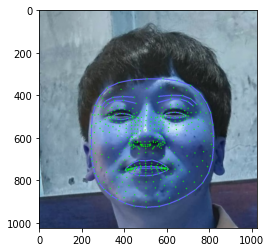

In [49]:
img = cv2.imread('./test_align.png',cv2.IMREAD_COLOR)
annotated_imagem, face_landmark_coord = mediapipe_infer(img, fm)
print(face_landmark_coord)
plt.imshow(annotated_image)

# Read and Write Video 

In [21]:
def video_infer(video_path, output_path) :
    cap = cv2.VideoCapture(video_path)

    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_cnt = round(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)



    out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    cnt = 1
    while True :

        ret, frame = cap.read()

        if ret :
            print(f"Complete [{cnt} / {frame_cnt}]",end="\r")
            cnt += 1

            landmark = mediapipe_infer(frame, fm)

            if landmark is None : 
                out.write(frame)
                continue

            out.write(landmark)

        else:
            break

    cap.release()
    out.release()


In [22]:
video_path = "test.mp4"
output_path = "output.avi"

video_infer(video_path, output_path)

## Face Detector 성능

### MTCNN
    - 옆 모습 잘 못찾음
    - 정확도가 너무 떨어짐
    - 삭제함
    
### MediaPipe
    - 일단 성능은 보장됨.
    - mediapipe로 multi face landmark 가능한지 확인하기 -> 싱글 페이스 먼저 ㄱㄱ
    - detection 능력 너무 떨어짐.
    - 일정 거리 이상되면 얼굴 못찾음
    - 일단 단거리 & 싱글페이스 먼저
    - face_landmark 좌표 가져온것 & opencv로 얼굴에 직접 찍어보기
    